In [25]:
# =========================
# 1️⃣ CARGAR CSV
# =========================
import pandas as pd

# Cambia esto al nombre exacto de tu archivo CSV
csv_file = "XRPUSDTUSDT_5m_2000.csv"

# Cargar CSV
df = pd.read_csv(csv_file)

# Mostrar las primeras filas
df.head()


,timestamp,open,high,low,close,volume,datetime
0,1758007200000,2.9910,2.9912,2.9861,2.9887,472847.1416,2025-09-16 07:20:00+00:00
1,1758007500000,2.9887,2.9940,2.9887,2.9929,635275.9313,2025-09-16 07:25:00+00:00
2,1758007800000,2.9929,2.9946,2.9892,2.9945,661769.5717,2025-09-16 07:30:00+00:00
3,1758008100000,2.9945,2.9955,2.9914,2.9927,155822.2669,2025-09-16 07:35:00+00:00
4,1758008400000,2.9927,2.9964,2.9909,2.9963,324435.7385,2025-09-16 07:40:00+00:00


In [66]:
import ccxt
import pandas as pd
from datetime import datetime, timezone
import time
import os

# ----------------- CONFIG -----------------
SYMBOL = "XRP/USDT:USDT"
TIMEFRAME = "5m"
MAX_CANDLES = 2000
CSV_FILE = f"{SYMBOL.replace('/','').replace(':','')}_{TIMEFRAME}_{MAX_CANDLES}.csv"

bitget = ccxt.bitget({'enableRateLimit': True})

def fetch_n_ohlcv(exchange, symbol, timeframe='5m', limit_total=2000, limit_per_call=1000):
    timeframe_ms = exchange.parse_timeframe(timeframe) * 1000
    now_ms = exchange.milliseconds()
    since = int(now_ms - (limit_total * timeframe_ms))
    all_rows = []

    while len(all_rows) < limit_total:
        to_fetch = min(limit_per_call, limit_total - len(all_rows))
        candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=to_fetch)
        if not candles:
            break
        if all_rows and candles[0][0] <= all_rows[-1][0]:
            candles = [c for c in candles if c[0] > all_rows[-1][0]]
        if not candles:
            break
        all_rows.extend(candles)
        since = all_rows[-1][0] + timeframe_ms
        time.sleep(exchange.rateLimit/1000 if hasattr(exchange, 'rateLimit') else 0.2)

    df = pd.DataFrame(all_rows, columns=['timestamp','open','high','low','close','volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    return df.iloc[-limit_total:].reset_index(drop=True)

# ----------------- CARGAR O ACTUALIZAR CSV -----------------
if os.path.exists(CSV_FILE):
    print(f"[INFO] Cargando CSV existente: {CSV_FILE}")
    df = pd.read_csv(CSV_FILE, parse_dates=['datetime'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    # Actualizamos con velas nuevas
    last_ts = int(df['timestamp'].iloc[-1])
    new_df = fetch_n_ohlcv(bitget, SYMBOL, TIMEFRAME)
    new_df = new_df[new_df['timestamp'] > last_ts]
    if not new_df.empty:
        df = pd.concat([df, new_df], ignore_index=True)
        df.to_csv(CSV_FILE, index=False)
        print(f"[INFO] CSV actualizado con {len(new_df)} velas nuevas")
else:
    print(f"[INFO] Descargando {MAX_CANDLES} velas para {SYMBOL}")
    df = fetch_n_ohlcv(bitget, SYMBOL, TIMEFRAME, limit_total=MAX_CANDLES)
    df.to_csv(CSV_FILE, index=False)
    print(f"[INFO] CSV guardado: {CSV_FILE}")

print(df.tail(5))



[INFO] Cargando CSV existente: XRPUSDTUSDT_5m_2000.csv
[INFO] CSV actualizado con 3 velas nuevas
          timestamp    open    high     low   close       volume  \
2163  1758656100000  2.8618  2.8621  2.8557  2.8601  371179.0000   
2164  1758656400000  2.8601  2.8631  2.8592  2.8631   28783.0000   
2165  1758656700000  2.8549  2.8564  2.8495  2.8505  772209.1898   
2166  1758657000000  2.8505  2.8526  2.8478  2.8517  470632.5949   
2167  1758657300000  2.8517  2.8529  2.8463  2.8491  123502.0434   

                      datetime  
2163 2025-09-23 19:35:00+00:00  
2164 2025-09-23 19:40:00+00:00  
2165 2025-09-23 19:45:00+00:00  
2166 2025-09-23 19:50:00+00:00  
2167 2025-09-23 19:55:00+00:00  


In [68]:
# =========================
# 2️⃣ LIMPIAR Y PREPARAR DATOS
# =========================
import numpy as np

# Asegurarnos de que las columnas correctas existen
expected_cols = ['timestamp','open','high','low','close','volume','datetime']
for col in expected_cols:
    if col not in df.columns:
        print(f"[WARN] Falta columna: {col}")

# Convertir tipos
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True, errors='coerce')
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

# Ordenar por tiempo (por si acaso)
df = df.sort_values('timestamp').reset_index(drop=True)


# Eliminar última fila (no tiene siguiente vela)
df = df.iloc[:-1]



#Cálculo de indicadores técnicos
# EMA, RSI y ATR como ejemplo
df['ema_fast'] = df['close'].ewm(span=5).mean()
df['ema_slow'] = df['close'].ewm(span=20).mean()

delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / (avg_loss + 1e-8)
df['rsi'] = 100 - (100 / (1 + rs))

high_low = df['high'] - df['low']
high_close = (df['high'] - df['close'].shift()).abs()
low_close = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['atr'] = tr.rolling(14).mean()

# Variable objetivo: cambio porcentual siguiente vela
df['target_change'] = df['close'].pct_change().shift(-1) * 100  # porcentaje
# Variable dirección: 1 = sube, 0 = baja
df['target_dir'] = (df['target_change'] > 0).astype(int)

df.dropna(inplace=True)
df.tail(5)

,timestamp,open,high,low,close,volume,datetime,ema_fast,ema_slow,rsi,atr,target_change,target_dir
2145,2025-09-23 19:15:00+00:00,2.8628,2.8689,2.8593,2.8682,787238.7797,2025-09-23 19:15:00+00:00,2.859996,2.855185,67.494628,0.007407,-0.083676,0
2146,2025-09-23 19:20:00+00:00,2.8682,2.8684,2.8622,2.8658,316086.3597,2025-09-23 19:20:00+00:00,2.861931,2.856196,63.507885,0.007264,-0.073278,0
2147,2025-09-23 19:25:00+00:00,2.8658,2.8663,2.8609,2.8637,322164.3216,2025-09-23 19:25:00+00:00,2.862521,2.856911,65.761812,0.007193,0.020952,1
2148,2025-09-23 19:30:00+00:00,2.8637,2.8646,2.8630,2.8643,3538.0000,2025-09-23 19:30:00+00:00,2.863114,2.857614,69.330244,0.006729,-0.146633,0
2149,2025-09-23 19:35:00+00:00,2.8618,2.8621,2.8557,2.8601,371179.0000,2025-09-23 19:35:00+00:00,2.862109,2.857851,66.322122,0.006729,0.104891,1


In [60]:
#Preparar X e Y para modelo de regresión y clasificación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['open','high','low','close','volume','ema_fast','ema_slow','rsi','atr']
X = df[features]
y_reg = df['target_change']       # % cambio siguiente vela
y_clf = df['target_dir']          # dirección siguiente vela

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar entrenamiento y test (última vela reservada para predicción real)
X_train = X_scaled[:-1]
X_test = X_scaled[-1].reshape(1, -1)
y_train_reg = y_reg[:-1]
y_train_clf = y_clf[:-1]
y_real_change = y_reg.iloc[-1]      # cambio real siguiente vela
y_real_dir = y_clf.iloc[-1]
ultimo_cierre = df['close'].iloc[-2]

In [62]:
import ccxt
import pandas as pd
import time

# Inicializar exchange Bitget (solo lectura pública)
bitget = ccxt.bitget({'enableRateLimit': True, 'timeout': 15000})

def fetch_new_ohlcv(symbol, timeframe, since=None, limit=1):
    """
    Trae la(s) vela(s) más reciente(s) desde el exchange después de 'since'.
    Devuelve un DataFrame con timestamp, open, high, low, close, volume.
    """
    try:
        ohlcv = bitget.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
        if ohlcv:
            df = pd.DataFrame(ohlcv, columns=['timestamp','open','high','low','close','volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
            return df
        else:
            return pd.DataFrame()  # vacío si no hay nuevas velas
    except Exception as e:
        print(f"[ERROR] fetch_new_ohlcv: {e}")
        return pd.DataFrame()


In [ ]:
ultimo = df.iloc[-1]
X_last = ultimo[features].values.reshape(1,-1)
X_last_scaled = scaler.transform(X_last)

# Predicción
pred_class = clf.predict(X_last_scaled)[0]
pred_pct = reg.predict(X_last_scaled)[0]  # % cambio predicho
pred_price = ultimo['close'] * (1 + pred_pct/100)

# Traer la siguiente vela real
df_next = fetch_new_ohlcv(SYMBOL, TIMEFRAME, since=int(ultimo['timestamp']))
if not df_next.empty:
    real_close = df_next['close'].iloc[0]
    real_pct = ((real_close - ultimo['close']) / ultimo['close']) * 100
    real_dir = 1 if real_close > ultimo['close'] else 0

    diff_price = real_close - pred_price
    diff_price_pct = (diff_price / real_close) * 100

    print("\n📊 Resultados de predicción vs mercado real")
    print(f"Última vela dataset: cierre = {ultimo['close']:.4f}")
    print(f"Predicción próxima vela: {pred_pct:.2f}% → Dirección: {'Sube' if pred_class==1 else 'Baja'}")
    print(f"Precio predicho: {pred_price:.4f}")
    print(f"Real próxima vela: {real_pct:.2f}% (cierre = {real_close:.4f}) → Dirección: {'Sube' if real_dir==1 else 'Baja'}")
    print(f"dirección: {'✅' if pred_class==real_dir else '❌'}")
    print(f"Diferencia magnitud %: {abs(pred_pct - real_pct):.2f}%")
    print(f"Diferencia precio predicho vs real: {diff_price:.4f} ({diff_price_pct:.2f}%)")
else:
    print("[INFO] No hay nueva vela disponible en el exchange aún.")


c:\Users\fernando berumen\Documents\Python Scripts\trading_spot\venv311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



📊 Resultados de predicción vs mercado real
Última vela dataset: cierre = 2.8601
Predicción próxima vela: -0.03% → Dirección: Baja
Precio predicho: 2.8594
Real próxima vela: -0.18% (cierre = 2.8549) → Dirección: Baja
Error dirección: ✅
Diferencia magnitud %: 0.16%
Diferencia precio predicho vs real: -0.0045 (-0.16%)


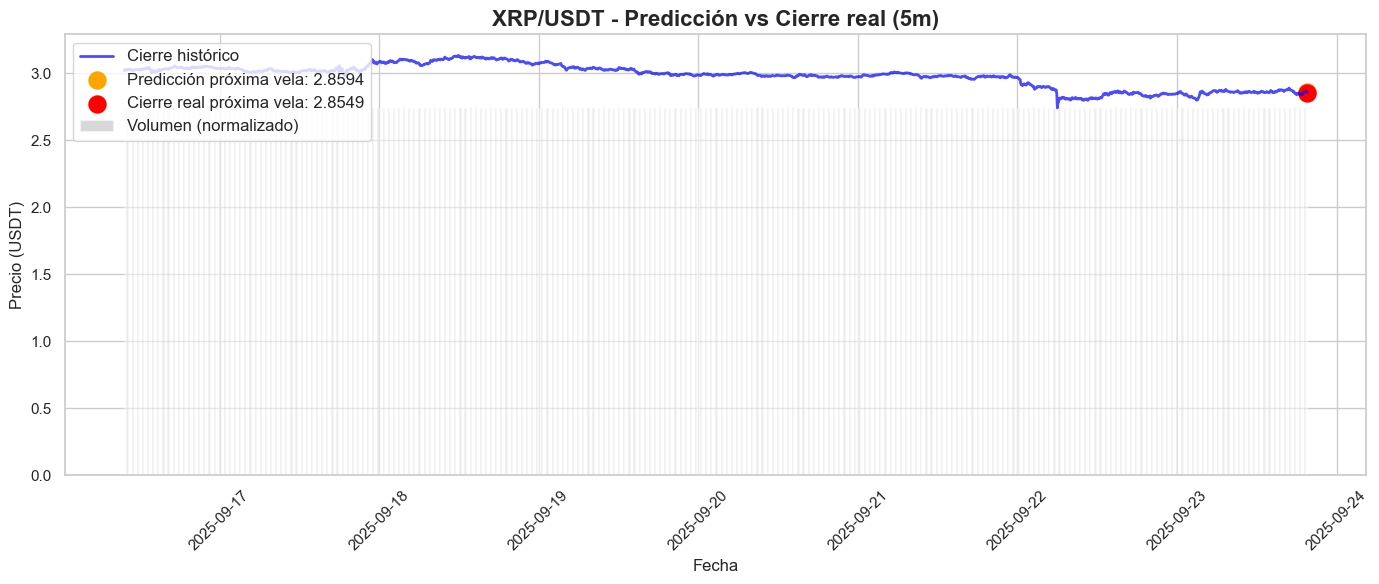

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Último cierre conocido
ultimo_cierre = df['close'].iloc[-1]

# Precio predicho de la próxima vela
pred_close = ultimo_cierre * (1 + pred_pct/100)

# Cierre real próxima vela
if not df_next.empty:
    real_close = df_next['close'].iloc[0]

# Graficar cierre histórico
plt.plot(df['datetime'], df['close'], label='Cierre histórico', color='blue', alpha=0.7, linewidth=2)

# Predicción próxima vela
plt.scatter(df['datetime'].iloc[-1], pred_close, color='orange', s=150, label=f'Predicción próxima vela: {pred_close:.4f}')

# Cierre real próxima vela
if not df_next.empty:
    plt.scatter(df['datetime'].iloc[-1], real_close, color='red', s=150, label=f'Cierre real próxima vela: {real_close:.4f}')

# Volumen como barras (opcional)
plt.bar(df['datetime'], df['volume']/df['volume'].max()* (df['close'].max()-df['close'].min())*0.5 + df['close'].min(), 
        width=0.0008, alpha=0.3, color='gray', label='Volumen (normalizado)')

# Títulos y etiquetas
plt.title(f"XRP/USDT - Predicción vs Cierre real ({TIMEFRAME})", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Precio (USDT)")

plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()




In [77]:
#FASE2  
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

def backtest_predictions(df, features, reg, clf, scaler, n=200):
    preds, reals, dirs_pred, dirs_real = [], [], [], []

    for i in range(len(df) - n, len(df) - 1):  # usar últimas N velas
        X_i = df.iloc[i][features].values.reshape(1, -1)
        X_i_scaled = scaler.transform(X_i)

        pred_pct = reg.predict(X_i_scaled)[0]
        pred_class = clf.predict(X_i_scaled)[0]

        real_pct = df['target_change'].iloc[i+1]
        real_dir = df['target_dir'].iloc[i+1]

        preds.append(pred_pct)
        reals.append(real_pct)
        dirs_pred.append(pred_class)
        dirs_real.append(real_dir)

    # Métricas
    rmse = mean_squared_error(reals, preds, squared=False)
    acc = accuracy_score(dirs_real, dirs_pred)
    print(f"\n📊 Backtest últimas {n} velas")
    print(f"RMSE cambio %: {rmse:.3f}")
    print(f"Accuracy dirección: {acc*100:.2f}%")

    return preds, reals, dirs_pred, dirs_real


In [78]:
import matplotlib.pyplot as plt

def plot_predictions(df, preds, reals, dirs_pred, dirs_real):
    plt.figure(figsize=(12,5))
    plt.plot(reals, label="Real % cambio", color="blue", alpha=0.7)
    plt.plot(preds, label="Predicho % cambio", color="orange", linestyle="--")

    # marcar aciertos/errores
    colors = ["green" if p==r else "red" for p,r in zip(dirs_pred, dirs_real)]
    plt.scatter(range(len(dirs_pred)), preds, c=colors, marker="o")

    plt.title("📈 Backtest Predicciones")
    plt.xlabel("Velas")
    plt.ylabel("% cambio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



🚨 BACKTESTING RESULTADOS 🚨
📈 Accuracy de dirección: 52.50%
📉 RMSE en % cambio: 0.2588
⚡ Precisión en alta volatilidad: 50.00%
Última predicción: -0.10% → Dirección: Baja
Último precio real: 2.8505 | Predicho: 2.8476


c:\Users\fernando berumen\Documents\Python Scripts\trading_spot\venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


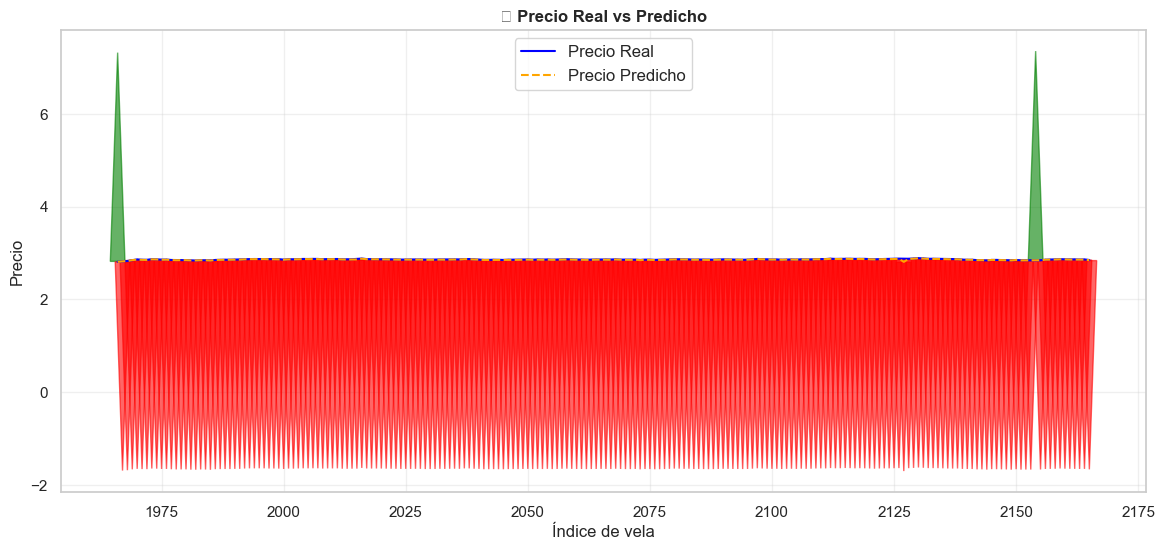

In [91]:
# ========================================
# 🔥 Proyecto Trading con Backtesting y Alertas en Consola
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# ==============================
# 1️⃣ Preparar datos
# ==============================
# Asumimos que ya cargaste tu dataframe "df" con columnas:
# timestamp, open, high, low, close, volume, datetime

# EMA
df['ema_fast'] = df['close'].ewm(span=5).mean()
df['ema_slow'] = df['close'].ewm(span=20).mean()

# RSI
delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-8)
df['rsi'] = 100 - (100 / (1 + rs))

# ATR
hl = df['high'] - df['low']
hc = (df['high'] - df['close'].shift()).abs()
lc = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
df['atr'] = tr.rolling(14).mean()

# Bollinger Bands
df['bb_mid'] = df['close'].rolling(20).mean()
df['bb_std'] = df['close'].rolling(20).std()
df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']

# VWAP
df['cum_vol'] = df['volume'].cumsum()
df['cum_vol_price'] = (df['close'] * df['volume']).cumsum()
df['vwap'] = df['cum_vol_price'] / df['cum_vol']

# Target variables
df['target_change'] = df['close'].pct_change().shift(-1) * 100
df['target_dir'] = (df['target_change'] > 0).astype(int)

df.dropna(inplace=True)

# ==============================
# 2️⃣ Features y split
# ==============================
features = ['open','high','low','close','volume',
            'ema_fast','ema_slow','rsi','atr',
            'bb_mid','bb_upper','bb_lower','vwap']

X = df[features]
y_reg = df['target_change']
y_clf = df['target_dir']

# Backtest en las últimas N velas
N = 200
X_train, X_test = X[:-N], X[-N:]
y_train_reg, y_test_reg = y_reg[:-N], y_reg[-N:]
y_train_clf, y_test_clf = y_clf[:-N], y_clf[-N:]
close_prices = df['close'][-N:]

# ==============================
# 3️⃣ Modelos
# ==============================
reg = RandomForestRegressor(n_estimators=100, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

reg.fit(X_train, y_train_reg)
clf.fit(X_train, y_train_clf)

# ==============================
# 4️⃣ Predicciones y backtesting
# ==============================
y_pred_reg = reg.predict(X_test)
y_pred_clf = clf.predict(X_test)

# Convertir % cambio en precios predichos
pred_prices = []
for i, pct in enumerate(y_pred_reg):
    pred_prices.append(close_prices.iloc[i] * (1 + pct/100))
pred_prices = np.array(pred_prices)

# ==============================
# 5️⃣ Métricas
# ==============================
acc = accuracy_score(y_test_clf, y_pred_clf)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

# Precisión en alta volatilidad
vol = np.std(y_test_reg)
high_vol_idx = (np.abs(y_test_reg) > vol).to_numpy()
dirs_real = np.array(y_test_clf)
dirs_pred = np.array(y_pred_clf)

if high_vol_idx.sum() > 0:
    high_vol_acc = accuracy_score(dirs_real[high_vol_idx], dirs_pred[high_vol_idx])
else:
    high_vol_acc = None

# ==============================
# 6️⃣ Alertas en consola
# ==============================
print("\n🚨 BACKTESTING RESULTADOS 🚨")
print(f"📈 Accuracy de dirección: {acc:.2%}")
print(f"📉 RMSE en % cambio: {rmse:.4f}")
print(f"⚡ Precisión en alta volatilidad: {high_vol_acc:.2%}" if high_vol_acc else "⚠️ No hubo velas de alta volatilidad")
print(f"Última predicción: {y_pred_reg[-1]:.2f}% → Dirección: {'Sube' if y_pred_clf[-1]==1 else 'Baja'}")
print(f"Último precio real: {close_prices.iloc[-1]:.4f} | Predicho: {pred_prices[-1]:.4f}")

# ==============================
# 7️⃣ Visualización
# ==============================
plt.figure(figsize=(14,6))
plt.plot(close_prices.index, close_prices.values, label='Precio Real', color='blue')
plt.plot(close_prices.index, pred_prices, label='Precio Predicho', color='orange', linestyle='--')

# Flechas de subida/bajada
for i in range(len(close_prices)):
    if y_pred_clf[i] == 1:
        plt.arrow(close_prices.index[i], pred_prices[i]-0.01, 0, 0.02,
                  color='green', alpha=0.6, head_width=3)
    else:
        plt.arrow(close_prices.index[i], pred_prices[i]+0.01, 0, -0.02,
                  color='red', alpha=0.6, head_width=3)

plt.title("📊 Precio Real vs Predicho")
plt.xlabel("Índice de vela")
plt.ylabel("Precio")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 2056, number of used features: 18
[LightGBM] [Info] Start training from score -0.002758
[LightGBM] [Info] Number of positive: 983, number of negative: 1073
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 2056, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478113 -> initscore=-0.087605
[LightGBM] [Info] Start training from score -0.087605

🚨 BACKTESTING COMPLETO 🚨
📈 Accuracy dirección: 48.00%
📉 RMSE % cambio: 0.1836
💰 Capital final simulado: $9976.10


c:\Users\fernando berumen\Documents\Python Scripts\trading_spot\venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


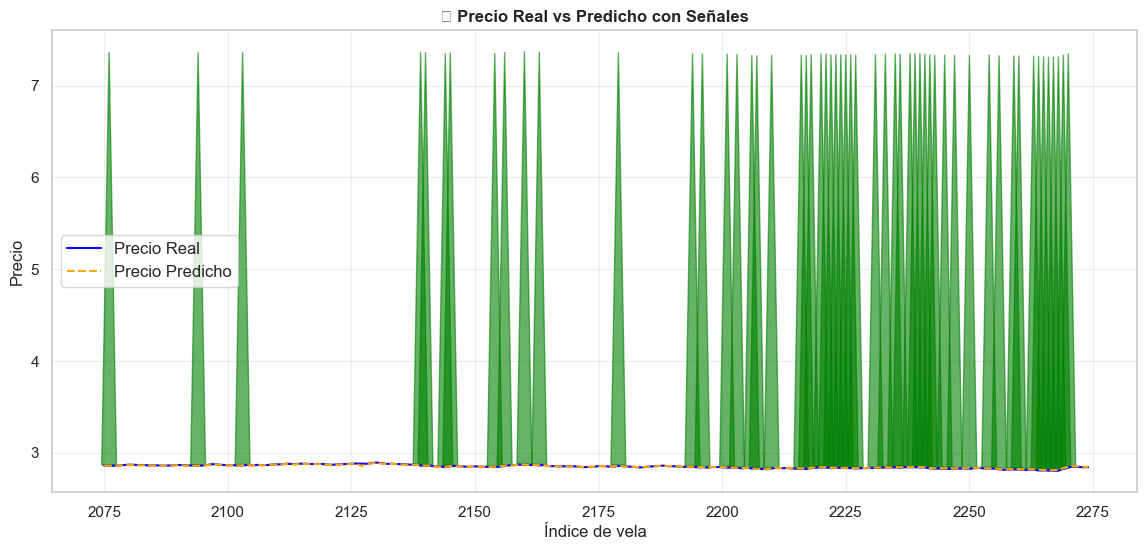

c:\Users\fernando berumen\Documents\Python Scripts\trading_spot\venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128185 (\N{CHART WITH UPWARDS TREND AND YEN SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


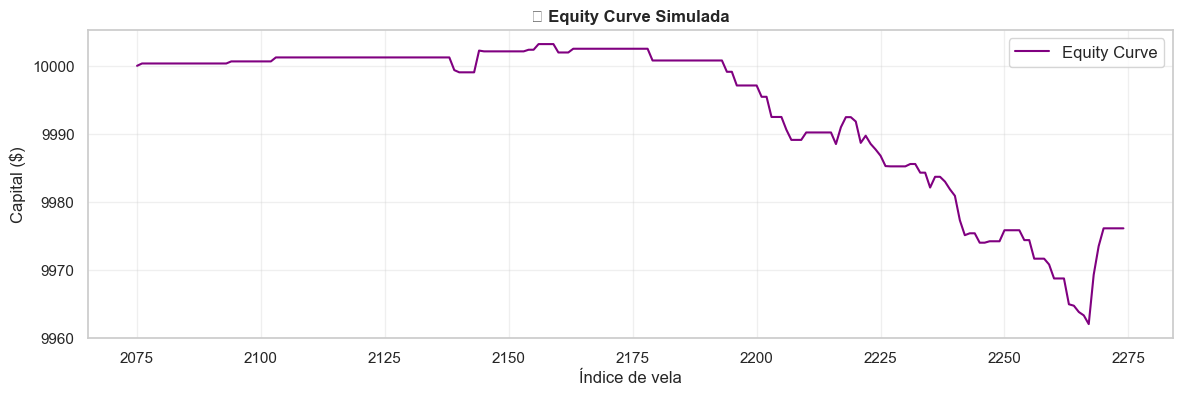

💲 Precio actual 112276.3400


NameError: name 'initial_capital' is not defined

In [ ]:
# ========================================
# 🔥 Proyecto Trading con Backtesting y Alertas en Consola
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import joblib
import lightgbm as lgb

# ==============================
# 1️⃣ Cargar datos históricos
# ==============================
# Puedes cargar tu CSV o dataframe
df = pd.read_csv('XRPUSDTUSDT_5m_2000.csv', parse_dates=['datetime'])
# Debe contener: timestamp, open, high, low, close, volume, datetime

# =================================
# 2️⃣ Calcular indicadores técnicos
# =================================
def compute_indicators(df):
    # EMA
    df['ema_fast'] = df['close'].ewm(span=5).mean()
    df['ema_slow'] = df['close'].ewm(span=20).mean()
    
    # RSI
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # ATR
    hl = df['high'] - df['low']
    hc = (df['high'] - df['close'].shift()).abs()
    lc = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    df['atr'] = tr.rolling(14).mean()
    
    # Bollinger Bands
    df['bb_mid'] = df['close'].rolling(20).mean()
    df['bb_std'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']
    
    # VWAP
    df['cum_vol'] = df['volume'].cumsum()
    df['cum_vol_price'] = (df['close'] * df['volume']).cumsum()
    df['vwap'] = df['cum_vol_price'] / df['cum_vol']
    
    # Momentum y ROC
    df['momentum'] = df['close'] - df['close'].shift(5)
    df['roc'] = df['close'].pct_change(periods=5) * 100
    
    # Volumen relativo
    df['vol_rel'] = df['volume'] / (df['volume'].rolling(20).mean() + 1e-8)
    
    # MACD
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    
    # Target
    df['target_change'] = df['close'].pct_change().shift(-1) * 100
    df['target_dir'] = (df['target_change'] > 0).astype(int)
    
    df.dropna(inplace=True)
    return df

# ==============================
# 3️⃣ Preparar features y split
# ==============================
def prepare_data(df):
    features = ['open','high','low','close','volume',
                'ema_fast','ema_slow','rsi','atr',
                'bb_mid','bb_upper','bb_lower','vwap',
                'momentum','roc','vol_rel','macd','macd_signal']
    X = df[features]
    y_reg = df['target_change']
    y_clf = df['target_dir']
    return X, y_reg, y_clf

# ==============================
# 4️⃣ Entrenar modelos
# ==============================
def train_models(X_train, y_train_reg, y_train_clf):
    # Random Forest
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    rf_reg.fit(X_train, y_train_reg)
    rf_clf.fit(X_train, y_train_clf)
    
    # LightGBM
    lgb_reg = lgb.LGBMRegressor(n_estimators=200)
    lgb_clf = lgb.LGBMClassifier(n_estimators=200)
    
    lgb_reg.fit(X_train, y_train_reg)
    lgb_clf.fit(X_train, y_train_clf)
    
    return rf_reg, rf_clf, lgb_reg, lgb_clf

# ==============================
# 5️⃣ Backtesting
# ==============================
def backtest(df, X_test, y_test_reg, y_test_clf, models, close_prices,
             fee=0.0005, stop_loss_pct=0.5, take_profit_pct=1.0, min_prob=0.6):
    rf_reg, rf_clf, lgb_reg, lgb_clf = models
    
    # Predicciones promedio entre RF y LGB
    y_pred_reg = (rf_reg.predict(X_test) + lgb_reg.predict(X_test)) / 2
    y_pred_clf_prob = (rf_clf.predict_proba(X_test) + lgb_clf.predict_proba(X_test)) / 2
    y_pred_clf = (y_pred_clf_prob[:,1] >= min_prob).astype(int)
    
    # Convertir % cambio en precios
    pred_prices = close_prices.values * (1 + y_pred_reg/100)
    
    # Backtest con equity
    capital = 10000
    equity_curve = []
    
    for i in range(len(close_prices)):
        price = close_prices.values[i]
        direction = y_pred_clf[i]
        prob = y_pred_clf_prob[i,1]
        position_size = 0.1 * capital if prob >= min_prob else 0  # 10% capital por señal confiable
        
        if position_size > 0:
            # Simular ganancia/perdida
            if direction == 1:
                # Long
                target_price = price * (1 + take_profit_pct/100)
                sl_price = price * (1 - stop_loss_pct/100)
            else:
                # Short
                target_price = price * (1 - take_profit_pct/100)
                sl_price = price * (1 + stop_loss_pct/100)
            
            # Resultado simple: asumimos que la vela siguiente alcanza target o stop loss
            next_price = close_prices.values[i+1] if i+1 < len(close_prices) else price
            if direction == 1:
                pnl = min(max(next_price, sl_price), target_price) - price
            else:
                pnl = price - min(max(next_price, sl_price), target_price)
            pnl -= fee * price
            capital += position_size * pnl / price
        
        equity_curve.append(capital)
    
    # Métricas
    acc = accuracy_score(y_test_clf, y_pred_clf)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    
    print("\n🚨 BACKTESTING COMPLETO 🚨")
    print(f"📈 Accuracy dirección: {acc:.2%}")
    print(f"📉 RMSE % cambio: {rmse:.4f}")
    print(f"💰 Capital final simulado: ${capital:.2f}")
    
    # Visualización
    plt.figure(figsize=(14,6))
    plt.plot(close_prices.index, close_prices.values, label='Precio Real', color='blue')
    plt.plot(close_prices.index, pred_prices, label='Precio Predicho', color='orange', linestyle='--')
    
    for i in range(len(close_prices)):
        if y_pred_clf[i]==1:
            plt.arrow(close_prices.index[i], pred_prices[i]-0.01, 0, 0.02,
                      color='green', alpha=0.6, head_width=3)
        elif y_pred_clf[i]==0 and y_pred_clf_prob[i,1]>=min_prob:
            plt.arrow(close_prices.index[i], pred_prices[i]+0.01, 0, -0.02,
                      color='red', alpha=0.6, head_width=3)
    
    plt.title("📊 Precio Real vs Predicho con Señales")
    plt.xlabel("Índice de vela")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Equity curve
    plt.figure(figsize=(14,4))
    plt.plot(close_prices.index, equity_curve, label='Equity Curve', color='purple')
    plt.title("💹 Equity Curve Simulada")
    plt.xlabel("Índice de vela")
    plt.ylabel("Capital ($)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# ==============================
# 6️⃣ Obtener precio en tiempo real con CCXT
# ==============================
def get_realtime_price(exchange_name='binance', symbol='BTC/USDT'):
    exchange_class = getattr(ccxt, exchange_name)
    exchange = exchange_class()
    ticker = exchange.fetch_ticker(symbol)
    return ticker['last']

# ==============================
# 7️⃣ Flujo principal
# ==============================
# df = pd.read_csv('datos.csv', parse_dates=['datetime'])
df = compute_indicators(df)
X, y_reg, y_clf = prepare_data(df)

N = 200  # últimas velas para backtest
X_train, X_test = X[:-N], X[-N:]
y_train_reg, y_test_reg = y_reg[:-N], y_reg[-N:]
y_train_clf, y_test_clf = y_clf[:-N], y_clf[-N:]
close_prices = df['close'][-N:]

models = train_models(X_train, y_train_reg, y_train_clf)
backtest(df, X_test, y_test_reg, y_test_clf, models, close_prices)

# Último precio real
last_price = get_realtime_price()
print(f"💲 Precio actual {last_price:.4f}")



In [101]:
# ========================================
# 🔥 Proyecto Trading XRP/USDT 5m - Completo y sin errores
# ========================================
import pandas as pd
import numpy as np
import ccxt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import os
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import product

# ==============================
# Configuración
# ==============================
symbol = "XRP/USDT:USDT"
csv_file = "xrp_usdt_5m.csv"
prediction_file = "xrp_usdt_predictions.csv"
exchange = ccxt.bitget()
timeframe = '5m'

# ==============================
# 1️⃣ Leer y actualizar CSV
# ==============================
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    print(f"📂 CSV cargado con {len(df)} velas")
else:
    df = pd.DataFrame()
    print("⚠️ CSV no encontrado, se creará uno nuevo")

def fetch_new_candles(df, symbol, timeframe='5m', limit=2000):
    since = None if df.empty else int(df['timestamp'].iloc[-1]) + 1
    candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    new_df = pd.DataFrame(candles, columns=['timestamp','open','high','low','close','volume'])
    new_df['datetime'] = pd.to_datetime(new_df['timestamp'], unit='ms', errors='coerce')
    new_df.dropna(subset=['datetime'], inplace=True)
    if not new_df.empty:
        df = pd.concat([df, new_df], ignore_index=True)
        df.drop_duplicates(subset=['timestamp'], inplace=True)
        df.sort_values('timestamp', inplace=True)
        df.to_csv(csv_file, index=False)
        print(f"✅ Dataset actualizado con {len(new_df)} nuevas velas")
    else:
        print("ℹ️ No hay velas nuevas")
    return df

df = fetch_new_candles(df, symbol)
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df.dropna(subset=['datetime'], inplace=True)

# ==============================
# 2️⃣ Calcular indicadores y features avanzados
# ==============================
def compute_indicators(df):
    df['ema_fast'] = df['close'].ewm(span=5).mean()
    df['ema_slow'] = df['close'].ewm(span=20).mean()

    # RSI
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))

    # ATR
    hl = df['high'] - df['low']
    hc = (df['high'] - df['close'].shift()).abs()
    lc = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    df['atr'] = tr.rolling(14).mean()

    # Bollinger Bands
    df['bb_mid'] = df['close'].rolling(20).mean()
    df['bb_std'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_mid'] + 2*df['bb_std']
    df['bb_lower'] = df['bb_mid'] - 2*df['bb_std']

    # VWAP
    df['cum_vol'] = df['volume'].cumsum()
    df['cum_vol_price'] = (df['close'] * df['volume']).cumsum()
    df['vwap'] = df['cum_vol_price'] / df['cum_vol']

    # Momentum y ROC
    df['momentum'] = df['close'] - df['close'].shift(5)
    df['roc'] = df['close'].pct_change(5)*100

    # Volumen relativo
    df['vol_rel'] = df['volume'] / (df['volume'].rolling(20).mean() + 1e-8)

    # MACD
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()

    # Variables de tiempo
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday

    # Target
    df['target_change'] = df['close'].pct_change().shift(-1)*100
    df['target_dir'] = (df['target_change'] > 0).astype(int)
    df.dropna(inplace=True)
    return df

df = compute_indicators(df)

# ==============================
# 3️⃣ Preparar features y split
# ==============================
features = ['open','high','low','close','volume','ema_fast','ema_slow','rsi','atr',
            'bb_mid','bb_upper','bb_lower','vwap','momentum','roc','vol_rel',
            'macd','macd_signal','hour','weekday']

X = df[features]
y_reg = df['target_change']
y_clf = df['target_dir']

N = 200
X_train, X_test = X[:-N], X[-N:]
y_train_reg, y_test_reg = y_reg[:-N], y_reg[-N:]
y_train_clf, y_test_clf = y_clf[:-N], y_clf[-N:]
close_prices = df['close'][-N:]

# ==============================
# 4️⃣ Entrenar RandomForest
# ==============================
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_reg.fit(X_train, y_train_reg)
rf_clf.fit(X_train, y_train_clf)

# ==============================
# 5️⃣ Predicciones y backtesting
# ==============================
y_pred_reg = rf_reg.predict(X_test)
y_pred_clf_prob = rf_clf.predict_proba(X_test)[:,1]
y_pred_clf = (y_pred_clf_prob>=0.7).astype(int)

pred_prices = close_prices.values*(1+y_pred_reg/100)

capital = 10000
fee = 0.0005
stop_loss_pct = 0.5
take_profit_pct = 1.0
equity_curve = []

for i in range(len(close_prices)):
    price = close_prices.values[i]
    direction = y_pred_clf[i]
    prob = y_pred_clf_prob[i]
    position_size = 0.1*capital if prob>=0.7 else 0
    pnl = 0
    if position_size>0:
        if direction==1:
            target = price*(1+take_profit_pct/100)
            sl = price*(1-stop_loss_pct/100)
        else:
            target = price*(1-take_profit_pct/100)
            sl = price*(1+stop_loss_pct/100)
        next_price = close_prices.values[i+1] if i+1<len(close_prices) else price
        if direction==1:
            pnl = min(max(next_price,sl),target)-price
        else:
            pnl = price - min(max(next_price,sl),target)
        pnl -= fee*price
        capital += position_size*pnl/price
    equity_curve.append(capital)

# ==============================
# 6️⃣ Métricas y alta volatilidad
# ==============================
acc = accuracy_score(y_test_clf, (y_pred_clf_prob>=0.5).astype(int))
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
vol = np.std(y_test_reg)
high_vol_idx = np.abs(y_test_reg)>vol
high_vol_acc = accuracy_score(y_test_clf[high_vol_idx], ((y_pred_clf_prob>=0.5).astype(int))[high_vol_idx]) if high_vol_idx.sum()>0 else None

# ==============================
# 7️⃣ Guardar resultados históricos
# ==============================
results = pd.DataFrame({
    'datetime': df['datetime'][-N:],
    'close': close_prices.values,
    'pred_price': pred_prices,
    'pred_dir': y_pred_clf,
    'pred_prob': y_pred_clf_prob,
    'real_dir': y_test_clf.values,
    'target_change': y_test_reg.values
})
if os.path.exists(prediction_file):
    hist = pd.read_csv(prediction_file, parse_dates=['datetime'])
    results = pd.concat([hist, results], ignore_index=True)
results.to_csv(prediction_file, index=False)
print(f"📂 Predicciones históricas guardadas en {prediction_file}")

# ==============================
# 8️⃣ Resultados completos y claros
# ==============================
last_pred_dir = 'Sube' if y_pred_clf[-1]==1 else 'Baja'
last_pred_pct = y_pred_reg[-1]
last_prob = y_pred_clf_prob[-1]

equity_array = np.array(equity_curve)
max_drawdown = np.max(np.maximum.accumulate(equity_array) - equity_array)

correct_dir = (results['pred_dir']==results['real_dir']).sum()
total_dir = len(results)
avg_error_pct = np.mean(np.abs(results['pred_price'] - results['close']))

print("\n🚨 BACKTESTING RESULTADOS 🚨")
print(f"📈 Accuracy de dirección: {acc:.2%} ({correct_dir}/{total_dir} predicciones correctas)")
print(f"📉 RMSE en % cambio: {rmse:.4f}")
print(f"⚡ Precisión en alta volatilidad: {high_vol_acc:.2%}" if high_vol_acc else "⚠️ No hubo velas de alta volatilidad")
print(f"Última predicción: {last_pred_pct:.2f}% → Dirección: {last_pred_dir} | Probabilidad: {last_prob:.2%}")
print(f"Último precio real: {close_prices.iloc[-1]:.4f} | Predicho: {pred_prices[-1]:.4f}")
print(f"💰 Equity final: {capital:.2f} USDT | Max Drawdown: {max_drawdown:.2f}")
print(f"🔹 Promedio de error absoluto de predicción: {avg_error_pct:.4f} USDT")

# ==============================
# 9️⃣ Optimización automática de parámetros
# ==============================
initial_capital = 10000
test_window = 50  # tamaño de cada ventana de prueba

prob_values = [0.65,0.7,0.75,0.8]
train_windows = [150,200,250]
tp_sl_ratios = [0.5,1.0,1.5]  # multiplicador sobre ATR

best_metrics = {'acc':0, 'drawdown':np.inf, 'params':None}
close_full = df['close'].values
atr_full = df['atr'].values

for prob, tw, ratio in product(prob_values, train_windows, tp_sl_ratios):
    capital_tmp = initial_capital
    equity_tmp = []
    for start in range(0, len(X)-tw-test_window, test_window):
        X_train = X[start:start+tw]
        y_train_clf = y_clf[start:start+tw]
        X_test_win = X[start+tw:start+tw+test_window]
        y_test_win = y_clf[start+tw:start+tw+test_window]
        close_test = close_full[start+tw:start+tw+test_window]
        atr_test = atr_full[start+tw:start+tw+test_window]

        rf_clf_tmp = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_clf_tmp.fit(X_train, y_train_clf)
        y_pred_prob = rf_clf_tmp.predict_proba(X_test_win)[:,1]
        y_pred = (y_pred_prob>=prob).astype(int)

        # Equity simulation
        for i in range(len(close_test)):
            direction = y_pred[i]
            psize = 0.1*capital_tmp if y_pred_prob[i]>=prob else 0
            pnl = 0
            if psize>0:
                tp = close_test[i] + ratio*atr_test[i] if direction==1 else close_test[i] - ratio*atr_test[i]
                sl = close_test[i] - ratio*atr_test[i] if direction==1 else close_test[i] + ratio*atr_test[i]
                next_price = close_test[i+1] if i+1<len(close_test) else close_test[i]
                if direction==1:
                    pnl = min(max(next_price,sl),tp)-close_test[i]
                else:
                    pnl = close_test[i]-min(max(next_price,sl),tp)
                pnl -= fee*close_test[i]
                capital_tmp += psize*pnl/close_test[i]
            equity_tmp.append(capital_tmp)

    equity_array_tmp = np.array(equity_tmp)
    max_dd = np.max(np.maximum.accumulate(equity_array_tmp)-equity_array_tmp)
    acc_tmp = np.mean(y_pred==y_test_win[:len(y_pred)])

    if acc_tmp>best_metrics['acc'] and max_dd<best_metrics['drawdown']:
        best_metrics['acc'] = acc_tmp
        best_metrics['drawdown'] = max_dd
        best_metrics['params'] = {'min_prob':prob,'train_window':tw,'tp_sl_ratio':ratio}

print("\n🛠️ OPTIMIZACIÓN FINAL COMPLETA")
print(f"Mejor accuracy histórico: {best_metrics['acc']:.2%}")
print(f"Drawdown máximo: {best_metrics['drawdown']:.2f}")
print(f"Parámetros óptimos: {best_metrics['params']}")


📂 CSV cargado con 1006 velas
ℹ️ No hay velas nuevas
📂 Predicciones históricas guardadas en xrp_usdt_predictions.csv

🚨 BACKTESTING RESULTADOS 🚨
📈 Accuracy de dirección: 52.50% (443/800 predicciones correctas)
📉 RMSE en % cambio: 0.2472
⚡ Precisión en alta volatilidad: 50.91%
Última predicción: 0.03% → Dirección: Baja | Probabilidad: 43.00%
Último precio real: 2.8411 | Predicho: 2.8418
💰 Equity final: 10009.82 USDT | Max Drawdown: 2.21
🔹 Promedio de error absoluto de predicción: 0.0016 USDT

🛠️ OPTIMIZACIÓN FINAL COMPLETA
Mejor accuracy histórico: 64.00%
Drawdown máximo: 34.62
Parámetros óptimos: {'min_prob': 0.8, 'train_window': 150, 'tp_sl_ratio': 0.5}


📂 CSV cargado con 1006 velas
✅ Dataset actualizado con 165 nuevas velas
⏰ Última vela en dataset (UTC): 2025-09-24 19:05:00
📂 Predicciones históricas guardadas en xrp_usdt_predictions.csv

🚨 BACKTESTING RESULTADOS 🚨
📈 Accuracy de dirección: 51.00% (542/1000 predicciones correctas)
📉 RMSE en % cambio: 0.2108
⚡ Precisión en alta volatilidad: 42.22%
Última predicción: -0.07% → Dirección: Baja | Probabilidad: 29.00%
Último precio real: 2.9538 | Predicho: 2.9518
💰 Equity final: 10003.56 USDT | Max Drawdown: 2.93
🔹 Promedio de error absoluto de predicción: 0.0016 USDT


c:\Users\fernando berumen\Documents\Python Scripts\trading_spot\venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


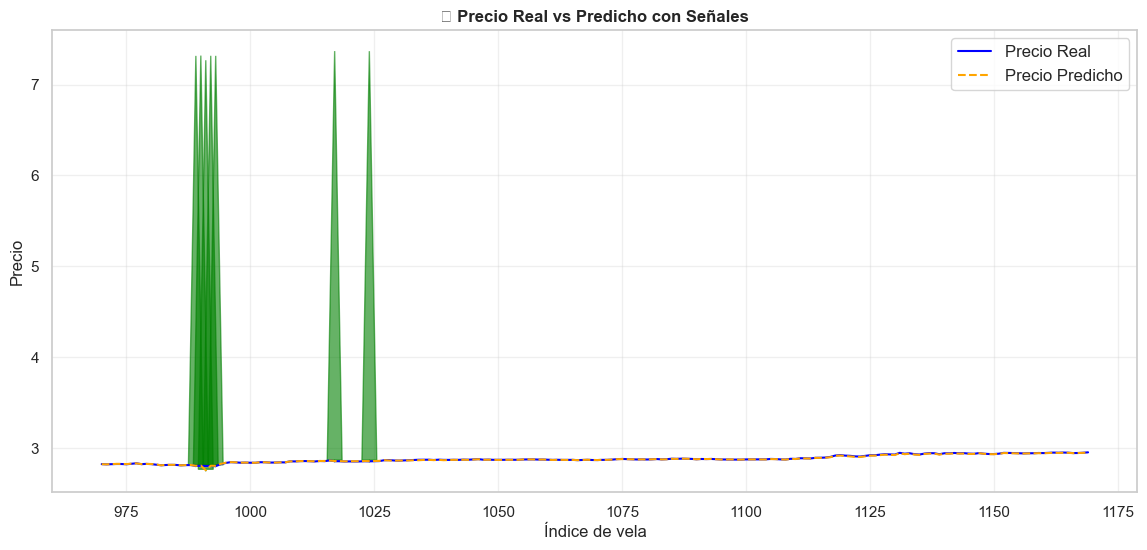

c:\Users\fernando berumen\Documents\Python Scripts\trading_spot\venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128185 (\N{CHART WITH UPWARDS TREND AND YEN SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


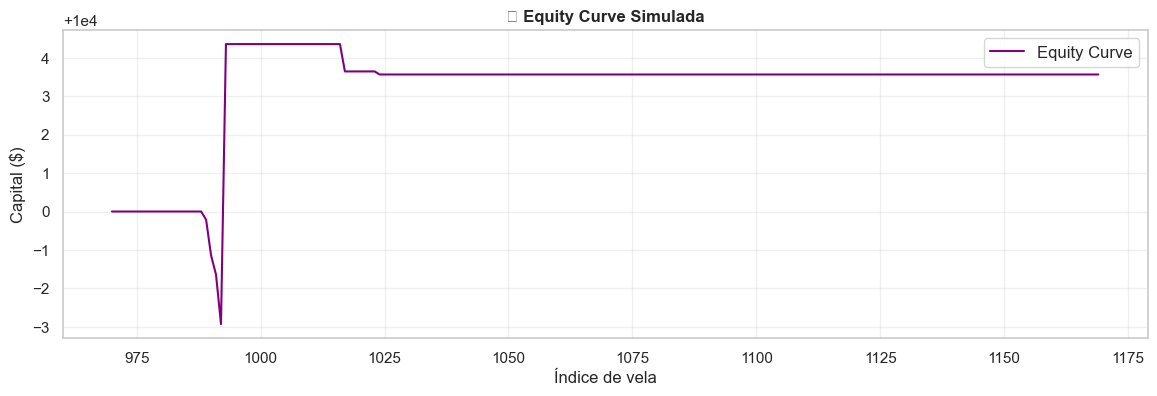

In [102]:
# ========================================
# 🔥 Proyecto Trading XRP/USDT 5m - Backtesting + Visualización
# ========================================
import pandas as pd
import numpy as np
import ccxt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# ==============================
# Configuración
# ==============================
symbol = "XRP/USDT:USDT"
csv_file = "xrp_usdt_5m.csv"
prediction_file = "xrp_usdt_predictions.csv"
exchange = ccxt.bitget()
timeframe = '5m'
retrain_threshold = 50  # Reentrenar si hay al menos 50 nuevas velas
initial_capital = 10000
min_prob = 0.7  # umbral para abrir trades

# ==============================
# 1️⃣ Leer y actualizar CSV
# ==============================
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    print(f"📂 CSV cargado con {len(df)} velas")
else:
    df = pd.DataFrame()
    print("⚠️ CSV no encontrado, se creará uno nuevo")

def fetch_new_candles(df, symbol, timeframe='5m', limit=2000):
    since = None if df.empty else int(df['timestamp'].iloc[-1]) + 1
    candles = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    new_df = pd.DataFrame(candles, columns=['timestamp','open','high','low','close','volume'])
    new_df['datetime'] = pd.to_datetime(new_df['timestamp'], unit='ms', errors='coerce')
    new_df.dropna(subset=['datetime'], inplace=True)
    if not new_df.empty:
        df = pd.concat([df, new_df], ignore_index=True)
        df.drop_duplicates(subset=['timestamp'], inplace=True)
        df.sort_values('timestamp', inplace=True)
        df.to_csv(csv_file, index=False)
        print(f"✅ Dataset actualizado con {len(new_df)} nuevas velas")
    else:
        print("ℹ️ No hay velas nuevas")
    return df, len(new_df)

df, new_count = fetch_new_candles(df, symbol)
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df.dropna(subset=['datetime'], inplace=True)
print(f"⏰ Última vela en dataset (UTC): {df['datetime'].iloc[-1]}")

# ==============================
# 2️⃣ Calcular indicadores
# ==============================
def compute_indicators(df):
    df['ema_fast'] = df['close'].ewm(span=5).mean()
    df['ema_slow'] = df['close'].ewm(span=20).mean()
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))
    hl = df['high'] - df['low']
    hc = (df['high'] - df['close'].shift()).abs()
    lc = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([hl,hc,lc], axis=1).max(axis=1)
    df['atr'] = tr.rolling(14).mean()
    df['bb_mid'] = df['close'].rolling(20).mean()
    df['bb_std'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_mid'] + 2*df['bb_std']
    df['bb_lower'] = df['bb_mid'] - 2*df['bb_std']
    df['cum_vol'] = df['volume'].cumsum()
    df['cum_vol_price'] = (df['close']*df['volume']).cumsum()
    df['vwap'] = df['cum_vol_price']/df['cum_vol']
    df['momentum'] = df['close'] - df['close'].shift(5)
    df['roc'] = df['close'].pct_change(5)*100
    df['vol_rel'] = df['volume']/(df['volume'].rolling(20).mean()+1e-8)
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df['target_change'] = df['close'].pct_change().shift(-1)*100
    df['target_dir'] = (df['target_change']>0).astype(int)
    df.dropna(inplace=True)
    return df

df = compute_indicators(df)

# ==============================
# 3️⃣ Preparar features y split
# ==============================
features = ['open','high','low','close','volume','ema_fast','ema_slow','rsi','atr',
            'bb_mid','bb_upper','bb_lower','vwap','momentum','roc','vol_rel',
            'macd','macd_signal','hour','weekday']
X = df[features]
y_reg = df['target_change']
y_clf = df['target_dir']
N = 200
X_train, X_test = X[:-N], X[-N:]
y_train_reg, y_test_reg = y_reg[:-N], y_reg[-N:]
y_train_clf, y_test_clf = y_clf[:-N], y_clf[-N:]
close_prices = df['close'][-N:]

# ==============================
# 4️⃣ Entrenar modelos
# ==============================
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train_reg)
rf_clf.fit(X_train, y_train_clf)

# ==============================
# 5️⃣ Predicciones y backtesting
# ==============================
y_pred_reg = rf_reg.predict(X_test)
y_pred_clf_prob = rf_clf.predict_proba(X_test)[:,1]
y_pred_clf = (y_pred_clf_prob>=min_prob).astype(int)
pred_prices = close_prices.values*(1+y_pred_reg/100)

capital = initial_capital
fee = 0.0005
stop_loss_pct = 0.5
take_profit_pct = 1.0
equity_curve = []

for i in range(len(close_prices)):
    price = close_prices.values[i]
    direction = y_pred_clf[i]
    prob = y_pred_clf_prob[i]
    position_size = 0.1*capital if prob>=min_prob else 0
    pnl = 0
    if position_size>0:
        if direction==1:
            target = price*(1+take_profit_pct/100)
            sl = price*(1-stop_loss_pct/100)
        else:
            target = price*(1-take_profit_pct/100)
            sl = price*(1+stop_loss_pct/100)
        next_price = close_prices.values[i+1] if i+1<len(close_prices) else price
        if direction==1:
            pnl = min(max(next_price,sl),target)-price
        else:
            pnl = price - min(max(next_price,sl),target)
        pnl -= fee*price
        capital += position_size*pnl/price
    equity_curve.append(capital)

# ==============================
# 6️⃣ Métricas y resultados
# ==============================
acc = accuracy_score(y_test_clf, (y_pred_clf_prob>=0.5).astype(int))
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
vol = np.std(y_test_reg)
high_vol_idx = np.abs(y_test_reg)>vol
high_vol_acc = accuracy_score(y_test_clf[high_vol_idx], ((y_pred_clf_prob>=0.5).astype(int))[high_vol_idx]) if high_vol_idx.sum()>0 else None

results = pd.DataFrame({
    'datetime': df['datetime'][-N:],
    'close': close_prices.values,
    'pred_price': pred_prices,
    'pred_dir': y_pred_clf,
    'pred_prob': y_pred_clf_prob,
    'real_dir': y_test_clf.values,
    'target_change': y_test_reg.values
})
if os.path.exists(prediction_file):
    hist = pd.read_csv(prediction_file, parse_dates=['datetime'])
    results = pd.concat([hist, results], ignore_index=True)
results.to_csv(prediction_file, index=False)
print(f"📂 Predicciones históricas guardadas en {prediction_file}")

last_pred_dir = 'Sube' if y_pred_clf[-1]==1 else 'Baja'
last_pred_pct = y_pred_reg[-1]
last_prob = y_pred_clf_prob[-1]
equity_array = np.array(equity_curve)
max_drawdown = np.max(np.maximum.accumulate(equity_array)-equity_array)
correct_dir = (results['pred_dir']==results['real_dir']).sum()
total_dir = len(results)
avg_error_pct = np.mean(np.abs(results['pred_price'] - results['close']))

print("\n🚨 BACKTESTING RESULTADOS 🚨")
print(f"📈 Accuracy de dirección: {acc:.2%} ({correct_dir}/{total_dir} predicciones correctas)")
print(f"📉 RMSE en % cambio: {rmse:.4f}")
print(f"⚡ Precisión en alta volatilidad: {high_vol_acc:.2%}" if high_vol_acc else "⚠️ No hubo velas de alta volatilidad")
print(f"Última predicción: {last_pred_pct:.2f}% → Dirección: {last_pred_dir} | Probabilidad: {last_prob:.2%}")
print(f"Último precio real: {close_prices.iloc[-1]:.4f} | Predicho: {pred_prices[-1]:.4f}")
print(f"💰 Equity final: {capital:.2f} USDT | Max Drawdown: {max_drawdown:.2f}")
print(f"🔹 Promedio de error absoluto de predicción: {avg_error_pct:.4f} USDT")

# ==============================
# 7️⃣ Gráficos
# ==============================
plt.figure(figsize=(14,6))
plt.plot(close_prices.index, close_prices.values, label='Precio Real', color='blue')
plt.plot(close_prices.index, pred_prices, label='Precio Predicho', color='orange', linestyle='--')
for i in range(len(close_prices)):
    if y_pred_clf[i]==1:
        plt.arrow(close_prices.index[i], pred_prices[i]-0.01, 0, 0.02,
                  color='green', alpha=0.6, head_width=3)
    elif y_pred_clf[i]==0 and y_pred_clf_prob[i]>=min_prob:
        plt.arrow(close_prices.index[i], pred_prices[i]+0.01, 0, -0.02,
                  color='red', alpha=0.6, head_width=3)
plt.title("📊 Precio Real vs Predicho con Señales")
plt.xlabel("Índice de vela")
plt.ylabel("Precio")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(close_prices.index, equity_curve, label='Equity Curve', color='purple')
plt.title("💹 Equity Curve Simulada")
plt.xlabel("Índice de vela")
plt.ylabel("Capital ($)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
